In [5]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [7]:
# Dataset paths in Kaggle
base_dir = '/kaggle/input/17flowerclasses/17flowerclasses'
train_dir = f'{base_dir}/train'
test_dir = f'{base_dir}/test'

# Image size
IMG_SIZE = 224
BATCH_SIZE = 32

In [8]:
# Function to preprocess images using EfficientNet's preprocess_input (includes normalization)
def preprocess_image(image, label):
    image = preprocess_input(image)
    return image, label

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int',  # Labels as integers (class indices), class names are inferred from folder names
    shuffle=True
)

# Load validation dataset (test folder as validation, no shuffle)
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

# Get class names (for reference, since labels are strings but mapped to ints)
class_names = train_ds.class_names
print(f"Class names: {class_names}")
print(f"Number of classes: {len(class_names)}")

# Apply preprocessing to both datasets
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

Found 1190 files belonging to 17 classes.


I0000 00:00:1763123290.105631      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 170 files belonging to 17 classes.
Class names: ['Bluebell', 'ButterCup', 'ColtsFoot', 'Cowslip', 'Crocus', 'Daffodil', 'Daisy', 'Dandelion', 'Fritillary', 'Iris', 'LilyValley', 'Pansy', 'Snowdrop', 'Sunflower', 'Tigerlily', 'WindFlower', 'tulip']
Number of classes: 17


In [9]:
# Load pre-trained EfficientNetB0 model
base_model = EfficientNetB0(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

# Freeze the base model initially
base_model.trainable = False

# Define the model with data augmentation layers
model = models.Sequential([
    # Data augmentation layers
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
    
    base_model,
    
    # Head layers
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(17, activation='softmax')  # 17 classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ ?                      │   0 (unbuilt) │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ ?                      │   0 (unbuilt) │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[early_stop]
)

Epoch 1/50


E0000 00:00:1763123377.260995      48 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1763123380.268309     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 222ms/step - accuracy: 0.4711 - loss: 1.9395 - val_accuracy: 0.8235 - val_loss: 0.8586
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.8782 - loss: 0.3946 - val_accuracy: 0.8706 - val_loss: 0.5344
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9177 - loss: 0.2518 - val_accuracy: 0.8882 - val_loss: 0.4140
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9494 - loss: 0.1575 - val_accuracy: 0.9000 - val_loss: 0.3137
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9548 - loss: 0.1584 - val_accuracy: 0.9059 - val_loss: 0.3018
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9431 - loss: 0.1754 - val_accuracy: 0.9118 - val_loss: 0.2719
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9541 - loss: 0.1248 - val_accuracy: 0.9176 - val_loss: 0.2674
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9610 - loss: 0.1284 - val_accuracy: 0.9059 - val_loss: 

In [11]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9014 - loss: 0.2376
Validation Accuracy: 92.35%


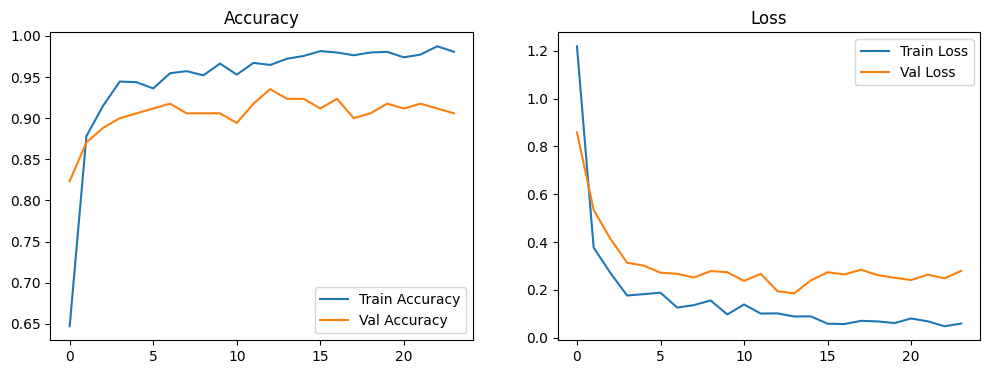

In [15]:
# Plot accuracy and loss

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()